# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

# 2.1 Upload the training and test datasets to a sagemaker directory

## 2.1.1 Read the training and test datasets from a local directory

In [1]:
import pandas as pd
import boto3, os
import sagemaker

from sklearn.model_selection import train_test_split

In [2]:
X_train = pd.read_csv(os.path.join(os.getcwd(), "Data","train_X.csv"))
Y_train = pd.read_csv(os.path.join(os.getcwd(), "Data","train_Y.csv"))
X_test = pd.read_csv(os.path.join(os.getcwd(), "Data","test_X.csv"))
Y_test = pd.read_csv(os.path.join(os.getcwd(), "Data","test_Y.csv"))

In [3]:
#check if all the required files exist in the local directory
def checkFileExists(filename, channel):
    if(os.path.exists(os.path.join(os.getcwd(), "Data", channel, filename))):
            print("{} exists!".format(filename))
            return True
    else:
        return False

def Train_Test_Val_Split():
    FilesExist_Mask = checkFileExists("train_X.csv",channel="Train") & checkFileExists("test_X.csv",channel="Test") &\
    checkFileExists("train_Y.csv",channel="Train") & checkFileExists("test_Y.csv",channel="Test")
    
    if(FilesExist_Mask):
        pass
    
    else:
        X_train = pd.read_csv(os.path.join(os.getcwd(), "Data","train_X.csv"))
        Y_train = pd.read_csv(os.path.join(os.getcwd(), "Data","train_Y.csv"))
        X_test = pd.read_csv(os.path.join(os.getcwd(), "Data","test_X.csv"))
        Y_test = pd.read_csv(os.path.join(os.getcwd(), "Data","test_Y.csv"))
        
        #Train test split to get the training, validation and test sets.
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)
        print("Shape of X_train: {}".format(X_train.shape))
        print("Shape of X_test: {}".format(X_val.shape))
        print("Shape of X_train: {}".format(Y_train.shape))
        print("Shape of X_train: {}".format(Y_val.shape))


        #delete the existing training CSV files on the local directory 
        os.remove(os.path.join(os.getcwd(), "Data","train_X.csv"))
        os.remove(os.path.join(os.getcwd(), "Data","train_Y.csv"))
        os.remove(os.path.join(os.getcwd(), "Data","test_X.csv"))
        os.remove(os.path.join(os.getcwd(), "Data","test_Y.csv"))

        #make directory for the train directory
        if(not os.path.exists(os.path.join(os.getcwd(), "Data", "Train"))):
            os.makedirs(os.path.join(os.getcwd(), "Data", "Train"))

        #make directory for the test directory
        if(not os.path.exists(os.path.join(os.getcwd(), "Data", "Test"))):
            os.makedirs(os.path.join(os.getcwd(), "Data", "Test"))

        #Upload the new training and test files to the local directory
        pd.DataFrame(X_train).to_csv(os.path.join(os.getcwd(), "Data","Train","train_X.csv"), index=False)
        pd.DataFrame(Y_train).to_csv(os.path.join(os.getcwd(), "Data","Train","train_Y.csv"), index=False)
        pd.DataFrame(X_test).to_csv(os.path.join(os.getcwd(), "Data", "Test","test_X.csv"), index=False)
        pd.DataFrame(Y_test).to_csv(os.path.join(os.getcwd(), "Data","Test","test_Y.csv"), index=False)

Now that the data has been read, we will proceed to split the training dataset into training and validation datasets respectively. This will be done through the __train_test_split__ function

In [4]:
Train_Test_Val_Split()

Shape of X_train: (17898, 295)
Shape of X_test: (5966, 295)
Shape of X_train: (17898, 1)
Shape of X_train: (5966, 1)


### 2.1.1.1 Checking for Class Imbalance

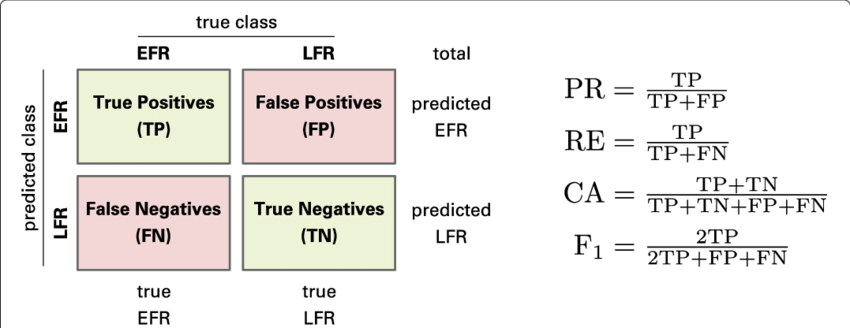
(URL: https://www.researchgate.net/figure/Confusion-matrix-Exemplified-CM-with-the-formulas-of-precision-PR-recall-RE_fig1_330174519)

Sometimes, when there is a class imbalance, the number of actual positive cases (chances of picking a customer is extremely low), the number of True Positive Cases and False Negative Cases are extremely low. Even if there are multiple inaccuracte false positives, the accuracy in this context would be falsely presented as a high value. 

On the other hand however, algorithmns such as precision, recall and F1 score would be nearing zero. To deal with class imbalances, we can oversample the minority class. 


In [5]:
def CheckClassImbalance():
    Y_train = pd.read_csv(os.path.join(os.getcwd(), "Data","Train","train_Y.csv"))
    Y_test = pd.read_csv(os.path.join(os.getcwd(), "Data","Test","test_Y.csv"))
    print("Number of labels on Y_train with 1: {}".format(Y_train.loc[Y_train.iloc[:,0]==1].shape))
    print("Number of labels on Y_train with 0: {}".format(Y_train.loc[Y_train.iloc[:,0]==0].shape))
    print("Number of labels on Y_test with 1: {}".format(Y_test.loc[Y_test.iloc[:,0]==1].shape))
    print("Number of labels on Y_test with 0: {}".format(Y_test.loc[Y_test.iloc[:,0]==0].shape))
    
CheckClassImbalance()

Number of labels on Y_train with 1: (217, 1)
Number of labels on Y_train with 0: (17681, 1)
Number of labels on Y_test with 1: (105, 1)
Number of labels on Y_test with 0: (10095, 1)


We can perform oversampling on the minority dataset prior to training. To perform the oversampling of the minority samples, we will use the SMOTE algorithmn.

In [7]:
!pip install imblearn

     |████████████████████████████████| 199 kB 30.4 MB/s            
     |████████████████████████████████| 199 kB 94.5 MB/s            
     |████████████████████████████████| 189 kB 96.4 MB/s            


In [8]:
from imblearn.over_sampling import SMOTE

def OverSample():
    Y_train = pd.read_csv(os.path.join(os.getcwd(), "Data","Train","train_Y.csv"))
    Y_test = pd.read_csv(os.path.join(os.getcwd(), "Data","Test","test_Y.csv"))
    X_train = pd.read_csv(os.path.join(os.getcwd(), "Data","Train","train_X.csv"))
    X_test = pd.read_csv(os.path.join(os.getcwd(), "Data","Test","test_X.csv"))
    
    print("Shape of train dataset before oversampling: {}".format(X_train.shape))
    print("Shape of train label before oversampling: {}".format(Y_train.shape))
    print("Shape of test dataset before oversampling: {}".format(X_test.shape))
    print("Shape of test label before oversampling: {}".format(Y_test.shape))
    
    X_resampled_train, Y_resampled_train = SMOTE().fit_resample(X_train, Y_train)
    X_resampled_test, Y_resampled_test = SMOTE().fit_resample(X_test, Y_test)
    
    print("\n\n")
    
    print("Shape of train dataset after oversampling: {}".format(X_resampled_train.shape))
    print("Shape of train label after oversampling: {}".format(Y_resampled_train.shape))
    print("Shape of test dataset after oversampling: {}".format(X_resampled_test.shape))
    print("Shape of test label after oversampling: {}".format(Y_resampled_test.shape))
    
    #Overwrite the newly concatenated dataset 
    X_resampled_train.to_csv(os.path.join(os.getcwd(), "Data","Train","train_X.csv"), index=False)
    X_resampled_test.to_csv(os.path.join(os.getcwd(), "Data","Test","test_X.csv"), index=False)
    Y_resampled_train.to_csv(os.path.join(os.getcwd(), "Data","Train","train_Y.csv"), index=False)
    Y_resampled_test.to_csv(os.path.join(os.getcwd(), "Data","Test","test_Y.csv"), index=False)
    
    #Check for class imbalance after oversampling
    print("\n\n")
    CheckClassImbalance()

In [9]:
OverSample()

Shape of train dataset before oversampling: (17898, 295)
Shape of train label before oversampling: (17898, 1)
Shape of test dataset before oversampling: (10200, 295)
Shape of test label before oversampling: (10200, 1)



Shape of train dataset after oversampling: (35362, 295)
Shape of train label after oversampling: (35362, 1)
Shape of test dataset after oversampling: (20190, 295)
Shape of test label after oversampling: (20190, 1)



Number of labels on Y_train with 1: (17681, 1)
Number of labels on Y_train with 0: (17681, 1)
Number of labels on Y_test with 1: (10095, 1)
Number of labels on Y_test with 0: (10095, 1)


## 2.1.2 Create a sagemaker session and S3 bucket

The sagemaker session will reference to the existing sagemaker session by default and bucket will point to the sagemaker default bucket.

In [10]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

## 2.1.3 Upload the files from the local directory to the S3 bucket

Our next step would be to upload the files from the local directory to the S3 bucket as csv files. This will be ingested into a train.py entry script which will perform the training for us. The prefix indicates the local subdirectory within the S3 bucket from which the data will be retrieved for training.

In [11]:
# should be the name of directory you created to save your features data
traindata_dir = os.path.join(os.getcwd(),"Data","Train")
testdata_dir = os.path.join(os.getcwd(),"Data","Test")

# set prefix, a descriptive name for a directory  
traindat_prefix = "arvato_datafiles/Train"
testdat_prefix = "arvato_datafiles/Test"

# upload all data to S3
trainpath = sagemaker_session.upload_data(path=traindata_dir, key_prefix=traindat_prefix)
testpath = sagemaker_session.upload_data(path=testdata_dir, key_prefix=testdat_prefix)

#Check to see if all the data has been uploaded successfully.
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

arvato_datafiles/Test/test_X.csv
arvato_datafiles/Test/test_Y.csv
arvato_datafiles/Train/train_X.csv
arvato_datafiles/Train/train_Y.csv
Test passed!


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


# 2.2 Create the Estimator Model

Once the data has been uploaded into the s3 bucket, a __train.py__ entry script that contains a custom scikit-learn classifier will:
* Loads training data from a specified directory
* Parses any training & model hyperparameters
* Instantiate a model with any specified hyperparams
* Trains that model 
* Finally, saves the model so that it can be hosted/deployed, later

Whilst there are a range of classifiers to choose from for devising an appropriate estimator model, the type of classifier and metrics formulated will be based upon the objective considered. The objective considered for this scenario would be to predict how likely a member of the general public in Germany would be a likely customer to Arvato Financial Services. As this is a binary classification project, we will look into 4 main algorithmns with high accuracies for handling Binary Classification:

1. Linear Support Vector Machines (Sklearn): For the classification problems with a high dimensionality, we can use LinearSVC model. It would work effectively for datasets with a high dimensionality, specifically for datasets whereby the number of features exceeds the number of dataset rows.


2. Naive Bayes Classifier - The classifier makes use of conditional probability based on Bayes' Theorem to measure the probability of an event occurring. It works well taking into account the assumption that each feature makes an equal contribution to the response outcome. It also assumes that these features are independent.


3. Decision Trees: Decision trees such as RandomForests is an ensemble method that consists of many decision trees to train a model. It is prone to overfitting on training data as small changes on the training data could change the outcome of the trees rapidly.

4. Gradient boosted trees: Algorithmns such as XGBoost can be applied directly on an unclean data containing mixed datatypes. However, it is prone to overfitting on training data as small changes on the training data could change the outcome of the trees rapidly.

We will proceed to write a function that takes in the sklearn models of the 4 classifiers, performs gridsearch and optimizes the model to its best hyperparameters. Amongst the gridsearch models, we will select the model with the highest accuracy score.




In [12]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
import os

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

def PrintLog(model_name, train_score, test_score):
    print("Model Name: {0}, Train Accuracy: {1}, Test Accuracy: {2}\n".format(model_name,train_score,test_score))

def RandomizedSearch(model_list, scoring_metric, X_train, Y_train, X_test, Y_test, cv):
    """
    Fit a classifier using GridSearchCV, compute accuracy metric
    
    INPUT:
    - model_list: list of classifiers of format ["RandomForest", RN]
    - score_metric: callable string to function RandomSearchCV scoring attribute
    - X_train (DataFrame): features of the training dataframe
    - Y_train (DataFrame): labels of the training dataframe
    - cv: number of folds during k-fold or stratified k-fold clustering
            
    OUTPUT:
    - classifier: fitted classifier
    - returns accuracy
    """
    
    best_estimators = []
    for model in model_list:
        model_name = model[0]
        classifier = model[1]       
        
        if(model_name=="SVC"):
            hyperparameters = {'C': np.logspace(1e-9, 1, num=10)}
            grid_svc = RandomizedSearchCV(estimator=classifier, param_distributions=hyperparameters, scoring=scoring_metric, cv=cv)
            grid_svc.fit(X_train, Y_train)
            print("Fitted for LinearSVC!")
            
            best_estimators.append({'estimator':grid_svc,\
                                    'Train accuracy':grid_svc.score(X_train,Y_train),\
                                    'Test accuracy':grid_svc.score(X_test, Y_test)})
            
            PrintLog(model_name, grid_svc.score(X_train,Y_train),grid_svc.score(X_test, Y_test))
            
            
        elif(model_name=="naive_bayes"):
            #Apply MinMaxScaler prior to dataprocessing
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
            
            hyperparameters = {'alpha':np.linspace(0,1,num=50)}
            grid_nb = RandomizedSearchCV(estimator=classifier, param_distributions=hyperparameters, scoring=scoring_metric, cv=cv)
            grid_nb.fit(X_train, Y_train)
            
            print("Fitted for Naive Bayes!")
            
            best_estimators.append({'estimator':grid_nb,\
                                    'Train accuracy':grid_nb.score(X_train,Y_train),\
                                    'Test accuracy':grid_nb.score(X_test, Y_test)})
            PrintLog(model_name, grid_nb.score(X_train,Y_train),grid_nb.score(X_test, Y_test))
            
        elif(model_name=="randomforest"):
            hyperparameters = {'n_estimators': [10,100],\
                              'max_features': ['auto', 'sqrt', 'log2']}
            grid_rf = RandomizedSearchCV(estimator=classifier, param_distributions=hyperparameters, scoring=scoring_metric, cv=cv)
            grid_rf.fit(X_train, Y_train)
            
            print("Fitted for Random Forest!")
            
            best_estimators.append({'estimator':grid_rf,\
                                    'Train accuracy':grid_rf.score(X_train,Y_train),\
                                    'Test accuracy':grid_rf.score(X_test, Y_test)})
            PrintLog(model_name, grid_rf.score(X_train,Y_train),grid_rf.score(X_test, Y_test))
            
        elif(model_name=="xgboost"):
            hyperparameters = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
             
            grid_xgb = RandomizedSearchCV(estimator=classifier, param_distributions=hyperparameters, scoring=scoring_metric, cv=cv)
            grid_xgb.fit(X_train, Y_train)
            
            print("Fitted for XGBoost!")
            
            best_estimators.append({'estimator':grid_xgb,\
                                    'Train accuracy':grid_xgb.score(X_train,Y_train),\
                                    'Test accuracy':grid_xgb.score(X_test, Y_test)})
            PrintLog(model_name, grid_xgb.score(X_train,Y_train),grid_xgb.score(X_test, Y_test))               
        
    return best_estimators
                                   
                                   
#Initialise the model list                                           
model_list = [("naive_bayes",MultinomialNB()),\
              ("randomforest",RandomForestClassifier()),\
              ("xgboost",GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,\
              max_depth=9,max_features='sqrt', subsample=0.8, random_state=10)),\
              ("SVC", LinearSVC(random_state=0, tol=1e-5))]

#read the newly created training and test datasets
X_train = pd.read_csv(os.path.join(os.getcwd(), "Data","Train","train_X.csv"))
Y_train = pd.read_csv(os.path.join(os.getcwd(), "Data","Train","train_Y.csv"))
X_test = pd.read_csv(os.path.join(os.getcwd(), "Data","Test","test_X.csv"))
Y_test = pd.read_csv(os.path.join(os.getcwd(), "Data","Test","test_Y.csv"))

print("Read training and test datasets!")
                                   
best_estimators = RandomizedSearch(model_list,\
                                   "accuracy",\
                                   X_train.values, Y_train.values.ravel(), X_test.values, Y_test.values, cv=3)

Read training and test datasets!
Fitted for Naive Bayes!
Model Name: naive_bayes, Train Accuracy: 0.6219105254227703, Test Accuracy: 0.558791480931154



/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitted for Random Forest!
Model Name: randomforest, Train Accuracy: 0.9999717210565013, Test Accuracy: 0.7

Fitted for XGBoost!
Model Name: xgboost, Train Accuracy: 0.9943159323567672, Test Accuracy: 0.9675086676572561



/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/pytorch_latest

Fitted for LinearSVC!
Model Name: SVC, Train Accuracy: 0.8028957638142639, Test Accuracy: 0.529172857850421



/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Here are the observations we can make about the results:
1. Linear Support Vector Machines/Linear Learner model work in this scenario but they work best where the features present are of high dimensionality. In this case, LinearSVC overtrains and predicts well on the training dataset but fails on the test dataset. Additionally, the training algorithmn also converges slowly, thus indicating it's lack of fit.

2. Naive Bayes classifier assumes predictors are independent and can be trained on less training data. However, in this context the classifier did not perform well due to dependencies within the variables.

3. Ensemble method such as RandomForests performed well but it is prone to overfitting on the training dataset.

4. GradientBoosted Trees with a learning rate of 0.1, optimum trees of 60 and a depth of 9, with a subsample less than 1 (undergoes Stochastic Gradient Descent) reduces variances but increases bias. Varying this parameter would allow users to find an optimal convergence.



Given these four algorithmns, the GradientBoosted Trees has been chosen to the estimator for this scenario due to its high accuracy and ease of retraining the model.

In [18]:
!pygmentize source_sklearn/train.py

from __future__ import print_function

import argparse
import os
import pandas as pd
import numpy as np

# sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. 
# from sklearn.externals import joblib
# Import joblib package directly
import joblib

## TODO: Import any additional libraries you need to define a model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model


#Complete the main code
if __name__ == '__main__':
    
    # All of the model parameters and training parameters are 

In [19]:
# your import and estimator code, here
from sagemaker.sklearn.estimator import SKLearn
import os
import joblib

#Create a sklearn estimator with an entry_point, instance type of ml.m4.xlarge, using scikit 0.20 and the following hyperparameters.


estimator = SKLearn(entry_point=os.path.join(os.getcwd(), "source_sklearn", "train.py"),
                    role=role,
                    instance_count=1,
                    instance_type = 'ml.c5.xlarge',
                    framework_version = "0.23-1",
                    base_job_name="GRADIENTBOOST",
                    hyperparameters={'min_samples_split':500, 'min_samples_leaf':50,\
                                     'subsample':0.8, 'epochs':100, 'batch-size':128, 'learning-rate':0.001})

In [20]:
estimator.fit({"train": trainpath}, wait=True)

2022-06-18 08:29:21 Starting - Starting the training job...
2022-06-18 08:29:45 Starting - Preparing the instances for trainingProfilerReport-1655540961: InProgress
......
2022-06-18 08:30:47 Downloading - Downloading input data...
2022-06-18 08:31:13 Training - Downloading the training image...
2022-06-18 08:31:48 Training - Training image download completed. Training in progress..2022-06-18 08:31:53,436 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-06-18 08:31:53,439 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-06-18 08:31:53,447 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-06-18 08:31:53,737 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-06-18 08:31:53,754 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-06-18 08:31:53,764 sagemaker-training-toolkit INFO     No GPUs detected (norma

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/min

In [21]:
predictor = estimator.deploy(initial_instance_count=1,
                            instance_type='ml.t2.medium')

-----------!

In [22]:
from sklearn.metrics import accuracy_score


#read the test dataset 
test_X = pd.read_csv(os.path.join(os.getcwd(), "Data", "Test", "test_X.csv"))
test_Y = pd.read_csv(os.path.join(os.getcwd(), "Data", "Test", "test_Y.csv"))

#randomly sample 10000 rows for 50 epochs
for i in range(50):
    input_val = test_X.sample(n=10000)
    input_label = test_Y.loc[input_val.index,:].values
    
    #Make predictions on the test dataset
    pred_Y = predictor.predict(input_val.values)

    #score 
    print("Accuracy score on test set: {}".format(accuracy_score(input_label,pred_Y)))
    
    

Accuracy score on test set: 0.9617
Accuracy score on test set: 0.9639
Accuracy score on test set: 0.9608
Accuracy score on test set: 0.9628
Accuracy score on test set: 0.9627
Accuracy score on test set: 0.965
Accuracy score on test set: 0.9622
Accuracy score on test set: 0.9591
Accuracy score on test set: 0.9613
Accuracy score on test set: 0.9624
Accuracy score on test set: 0.962
Accuracy score on test set: 0.9618
Accuracy score on test set: 0.9619
Accuracy score on test set: 0.9602
Accuracy score on test set: 0.9628
Accuracy score on test set: 0.9623
Accuracy score on test set: 0.9623
Accuracy score on test set: 0.9612
Accuracy score on test set: 0.9638
Accuracy score on test set: 0.9621
Accuracy score on test set: 0.9614
Accuracy score on test set: 0.9629
Accuracy score on test set: 0.9623
Accuracy score on test set: 0.9636
Accuracy score on test set: 0.9653
Accuracy score on test set: 0.9635
Accuracy score on test set: 0.9617
Accuracy score on test set: 0.9593
Accuracy score on test

In [23]:
# uncomment and fill in the line below!
predictor.delete_endpoint()

In [24]:
# deleting bucket, uncomment lines below

bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


[{'ResponseMetadata': {'RequestId': 'GJ1BXD8T2QYF6YR0',
   'HostId': 'OQ7ENH+IJp7WPQCAd1MWyMq8iQRMMNJiqseK6dI4wMsQ/X0ayw6k5hZGxydtI/7QNZYyLxbWNN4=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'OQ7ENH+IJp7WPQCAd1MWyMq8iQRMMNJiqseK6dI4wMsQ/X0ayw6k5hZGxydtI/7QNZYyLxbWNN4=',
    'x-amz-request-id': 'GJ1BXD8T2QYF6YR0',
    'date': 'Sat, 18 Jun 2022 10:30:53 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'GRADIENTBOOST-2022-06-18-08-24-38-330/profiler-output/system/training_job_end.ts'},
   {'Key': 'GRADIENTBOOST-2022-06-18-08-29-21-040/profiler-output/system/incremental/2022061808/1655542140.algo-1.json'},
   {'Key': 'GRADIENTBOOST-2022-06-18-08-29-21-040/profiler-output/system/incremental/2022061809/1655546040.algo-1.json'},
   {'Key': 'GRADIENTBOOST-2022-06-18-08-29-21-040/output/model.tar.gz'},
   {'Key': 'GRADIENTBOOST-2022-06-18-08-29-21-